# Q-Learning into FrozenLake Problem

I've been searching for some simple reinforcement learning applications in order to understand the concepts and intuition. This notebook is just my attempt to explain (what better way to learn than this) how I see this specific approach.

I don't intent to explain it all or go deep. I am actually following other people's work ([Arthur Juliani](https://medium.com/@awjuliani "Juliani's Medium") in this case - big thanks).

The links for the content this notebook is based on are:  
https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0  
https://gym.openai.com/envs/FrozenLake-v0/

## The Problem

This problem is one of the many environments to learn, test and apply reinforcements algorithms from the [Gym Toolkit](https://gym.openai.com/), check them out.

In this problem, we have a grid of tiles and a character has to navigate from a point A to a point B only using step-moves horizontally and vertically. The tiles positions are all predefined. The grid looks like this:


``
-------------Legend
[S][F][F][F] (S: starting point, safe)  
[F][H][F][H] (F: frozen surface, safe)  
[F][F][F][H] (H: hole, fall to your doom)  
[H][F][F][G] (G: goal, where the frisbee is located)  
``

Your goal is to go from "S" to "G" without falling into a hole. The environment has a "slippery" feature where you sometimes move in a unintentional direction in order to add some randomness (I will remove this feature to simplify my case).

The Gym toolkit provides an interface where you don't need to worry about the game, restrictions, etc. You just send commands and observe the outcome. Neat.

## The Approach

In this notebook, I will use a technique called Q-Learning, which is a very simplistic but maybe a good start to use some logic to solve this game.

This approach uses a table to store your preference for an action (action in this case is walking left, down, right or up) for each and possible position in the grid. This means it grows very fast with more complexity, and also the path taken to get to that tile doesn't matter that much.


To give a quick example, lets imagine we see only the first few rows for our example, lets name each tile:

<table>
  <tr>
    <td>[a]</td>
    <td>[b]</td>
    <td>[c]</td>
    <td>[d]</td>
  </tr>
  <tr>
    <td>[e]</td>
    <td>[f]</td>
    <td>[g]</td>
    <td>[a]</td>
  </tr>
</table>


This would generate the following table (random values, first few rows):

<table>
  <tr>
    <th></th>
    <th>left</th>
    <th>down</th>
    <th>right</th>
    <th>up</th>
  </tr>
  <tr>
    <td>**a**</td>
    <td>0</td>
    <td>0.5</td>
    <td>0.7</td>
    <td>0</td>
  </tr>
  <tr>
    <td>**b**</td>
    <td>0.2</td>
    <td>0.4</td>
    <td>0.1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>**c**</td>
    <td>0.3</td>
    <td>0.8</td>
    <td>0.2</td>
    <td>0</td>
  </tr>
  <tr>
    <td>**d**</td>
    <td>0.1</td>
    <td>0.9</td>
    <td>0</td>
    <td>0</td>
  </tr>
</table>

Each row represents a tile position, and each column is a action. This means that if you are at the "b" tile, there is no value in going up and the best action should be going down, since the expected reward for this action is the best for this position.

The algorithm starts with an initial empty table (lets call it Q-table) with zeros, meaning there are any rewards stored for any action in any position. We run several tryouts (lets call it episodes), this episodes are simply attempts to play the game that end when you reach the goal, fall into a hole or exceeds the arbitrary number of max steps.

For each step you decide the next action based on the expected future reward for that action.

After the action taken, you see the results and update the Q-table accordingly. If you are not finished yet, you take the next action, until the end of the episode.

I would like to bring attention to the two more interesting parts of this algorithm: the deciding of the next action and the Q-table update.

##### Deciding which action to take

At the start you wouldn't have values for actions so you have to use some randomness to decide, this should be happening less and less with knowledge about the results of actions, this gradual change is good because you don't simply stop trying new things unless you have more certainty about an action.

We do this using this formula:

$ \text{action_taken} = \text{action_with_max_value}( \text{stored_action_values} + \text{diminishing_randomness} )$

In which the "diminishing randomness" is a vector with same size as the stored action values vector with random values from the standard normal distribution that gets weighted down as the algorithm advances with more episodes. This is done in order to help the lack of information in the beginning but still helping to experiment other actions.



##### Updating the Q-Table

After observing the result of the action, you update the value by:

$ \text{new_expected_reward} = \text{old_stored_value} + \text{expected_future_value} $

Where the "Expected Future Value" is calculated by:

<sub> $ \text{expected_future_value} = \text{learning_rate} * (\text{reward_from_action} + \text{discount} * Max(\text{next_position_actions_rewards}) - \text{old_stored_value}) $ </sub>

Where there are two variables you have to tune depending on the problem. This method seems to work backwards, because our problem only gives the reward at the last correct step, so the table values would start to be built from the finish to the start.

## The Code

In [15]:
import gym
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
gym.envs.registration.register(
    id='FrozenLake_notSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery':False}
)

This register a new environment without the feature of slipperiness, for a first look I think is better to grasp how everything works

In [65]:
env = gym.make('FrozenLake_notSlippery-v0')
Q = np.zeros([env.observation_space.n,env.action_space.n])
lr = .8  # learning rate
y = .95  # "correction"/"penalty" for future rewards expectation
# Thanks to https://github.com/PraneetDutta for this optimal parameters
num_episodes = 250
jList = []  # list of steps taken
rList = []  # list of rewards
qList = []  # list of tables

After that we set some initial objects like out empty Q-Table, tuning variables, number of episodes, etc

In [66]:
for i in range(num_episodes):
    s = env.reset()  # starting fresh environment and episode variables
    rAll = 0  # sum of all rewards for this episode
    d = False  # "done" variable: indicates if the episode is finished
    j = 0  # steps counter
    while j < 99:
        j+=1
        rew_sto = Q[s,:]  # stored rewards for actions
        rew_rand = np.random.randn(1,env.action_space.n)*(1./(i+1))  # randomness to test other options
        a = np.argmax(rew_sto + rew_rand)  # deciding what action to take
        # executing action and storing results
        s1,r,d,_ = env.step(a)  # s1: next tile, r: reward, d: done?
        # updating Q-Table
        rew_step = Q[s,a]  # stored reward so far
        rew_fut = lr*(r + y*np.max(Q[s1,:]) - Q[s,a])  # expected future reward
        Q[s,a] = rew_step + rew_fut  # updating reward for step taken
        # setting up for next step
        rAll += r  # summing reward for posterior analysis
        s = s1  # updating tile position
        # verifying if game stoped (hole or goal reached)
        if d == True:
            break
    # appending episode results
    jList.append(j)
    rList.append(rAll)
    qList.append(Q.copy())

We stored the final Q-table, as well as how many steps it took to finish the problem and the rewards for each episode

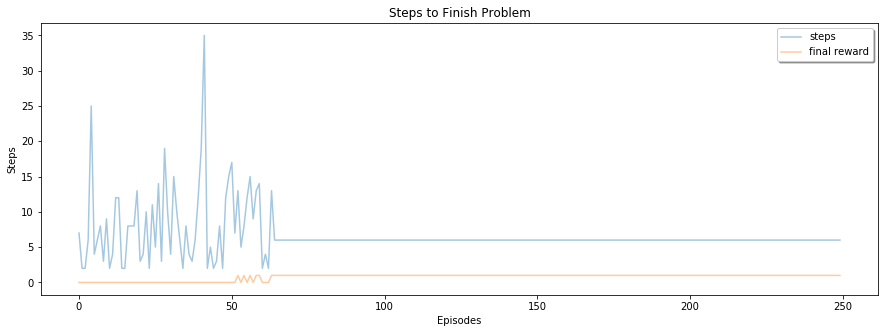

In [67]:
y_pos = [x for x in range(len(jList))]
fig, ax = plt.subplots(figsize=(15,5))
p1 = ax.plot(y_pos, jList, alpha=0.4, label='steps')
p2 = ax.plot(y_pos, rList, alpha=0.4, label='final reward')
ax.set_ylabel('Steps')
ax.set_xlabel('Episodes')
ax.set_title('Steps to Finish Problem')
ax.legend(loc='upper right', shadow=True)
plt.show()

The blue line show how many steps each episode took, and the brown one shows the reward for the episode. We can see some randomness until the Q-table stabilizes on the best values.

I would expect this graph to be a rough diminishingly curve, but the "holes" in the grid make it harder to achieve the goal. Running multiple times I observed the numbers of episodes to reach the best value being between 50 and 250.

As I suspected, this randomness is about getting to a known tile with a positive next action, once it is reached, the Q-table starts to build itself from the end to the start. But knowing half of the way seems to not help diminishing the number of steps until you know it all.

In [69]:
 Q

array([[0.        , 0.77378094, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.81450625, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.7023616 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.857375  , 0.        ],
       [0.        , 0.        , 0.9025    , 0.        ],
       [0.        , 0.95      , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

Looking at the final Q-Table we see that in general as you are approaching the goal tile, the expected reward value increases.